In [1]:
import networkx as nx # graphs

In [2]:
import numpy as np
import sys
import itertools
from numpy.linalg import norm
import matplotlib.pyplot as plt
import time 

In [3]:
def list_to_edges(path):
    edges = []
    for i in range(len(path) - 1):
        edges.append((path[i], path[i + 1]))
    return edges

In [4]:
def christofides_serdjukov(graph, mode=0):
    # Шаг 1: Построение минимального остовного дерева
    mst = nx.minimum_spanning_tree(graph)

    # Шаг 2: Поиск вершин с нечетной степенью в минимальном остовном дереве
    odd_degree_nodes = [node for node, degree in mst.degree() if degree % 2 == 1]

    # Шаг 3: Построение минимального паросочетания на подграфе, образованном вершинами с нечетной степенью
    odd_degree_subgraph = graph.subgraph(odd_degree_nodes)
    min_matching = nx.min_weight_matching(odd_degree_subgraph)
    
    # Шаг 4: Объединение минимального остовного дерева и минимального паросочетания
    eulerian_graph = nx.MultiGraph(mst)
    for edge in min_matching:
        eulerian_graph.add_edge(*edge)

    # Шаг 5: Построение эйлерова цикла в полученном графе
    eulerian_cycle = list(nx.eulerian_circuit(eulerian_graph))

    # Шаг 6: Удаление повторяющихся вершин
    visited = set()
    hampath = []
    for edge in eulerian_cycle:
        if edge[0] not in visited:
            visited.add(edge[0])
            hampath.append(edge[0])

    # Добавление последней вершины в путь
    hampath.append(eulerian_cycle[-1][1])
    
    edges = list_to_edges(hampath)
    if mode == 1:
        return hampath, 0
    opt = 0
    for e in edges:
        opt += graph.edges[e]['weight']
    
    return hampath, opt

In [5]:
def tsp_brute_force(graph):
    num_points = graph.number_of_nodes()
    min_distance = sys.maxsize
    min_path = []

    # Перебор всех возможных комбинаций вершин
    for path in itertools.permutations(range(num_points)):
        distance = 0
        for i in range(num_points - 1):
            distance += graph[path[i]][path[i+1]]['weight']

        # Добавление расстояния от последней вершины к первой
        distance += graph[path[-1]][path[0]]['weight']

        # Проверка на минимальное расстояние
        if distance < min_distance:
            min_distance = distance
            min_path = path
    
    min_path = list(min_path)
    min_path.append(min_path[0])
    
    return min_path, min_distance

In [6]:
def solve(V: np.array, i, mode=0):
    augm = V[np.newaxis, :]
    dists = augm - augm.reshape((-1, 1, 2))

    Mat = norm(dists, axis=-1)

    G = nx.from_numpy_array(Mat)
    
    hampath, computed = christofides_serdjukov(G, mode)
    if mode == 1:
        return
    path, opt = tsp_brute_force(G)
    
    return computed / opt

In [7]:
def generate_random_points_uniform(num_points, x_range, y_range):
    points = []
    for _ in range(num_points):
        x = np.random.uniform(0, x_range)
        y = np.random.uniform(0, y_range)
        points.append([x, y])
    return np.array(points)

In [8]:
def generate_random_points_gauss(num_points, num_clusters, cluster_std, x_range, y_range):
    mean = np.random.uniform(low=0, high=max(x_range, y_range), size=(num_clusters, 2))
    cov = np.diag([cluster_std] * 2)
    points = np.concatenate([np.random.multivariate_normal(m, cov, int(num_points / num_clusters)) for m in mean])

    points = np.clip(points, [0, 0], [x_range, y_range])

    return points

In [9]:
num_points = np.arange(2, 10, 1)
times_1 = []
times = []
cnt = 20
for points in num_points:
    mean_miss_uniform = 0
    mean_miss_gauss = 0
    for i in range(cnt):
        V_gauss = generate_random_points_gauss(points, points//3 + 1, 1/2, 20, 20)
        V_uniform = generate_random_points_uniform(points, 20, 20)
        dev_uniform = solve(V_uniform, 0)
        mean_miss_uniform += dev_uniform

        dev_gauss = solve(V_gauss, 0)
        mean_miss_gauss += dev_gauss
        
    mean_miss_uniform /= cnt
    mean_miss_gauss /= cnt
    print(points)
    times_1.append(mean_miss_uniform)
    times.append(mean_miss_gauss)

2
3
4
5
6
7
8
9


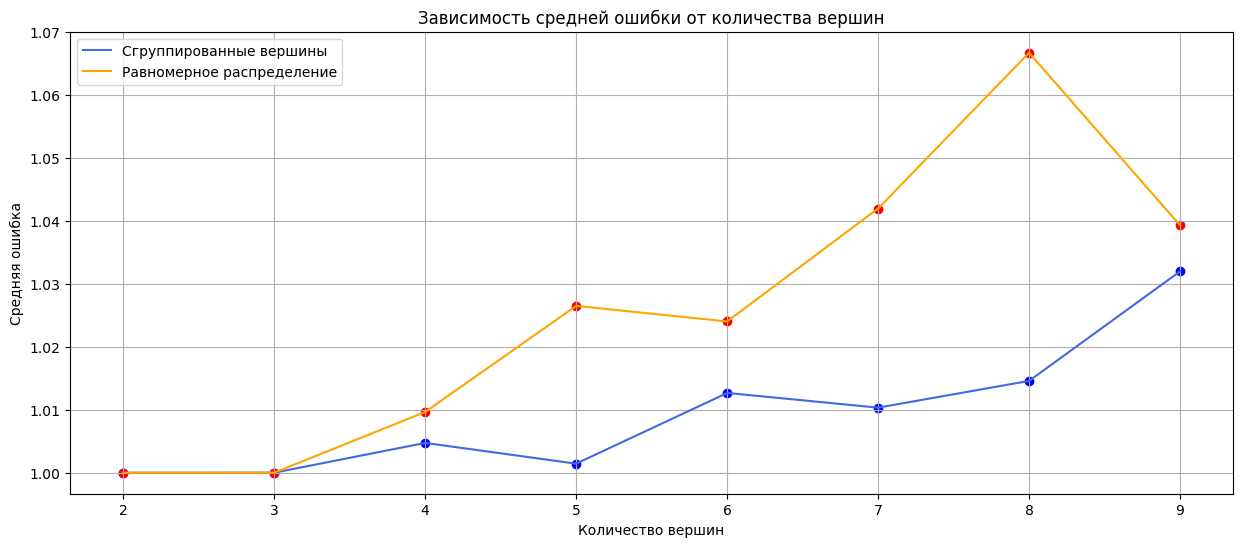

In [10]:
x_curve = np.linspace(min(num_points), max(num_points), 1000)
y_curve = np.interp(x_curve, num_points, times)
y_curve_1 = np.interp(x_curve, num_points, times_1)


# Построение графика
plt.figure( figsize=(15, 6))

plt.scatter(num_points, times, color='blue')
plt.plot(x_curve, y_curve, color='royalblue', label='Сгруппированные вершины')

plt.scatter(num_points, times_1, color='red')
plt.plot(x_curve, y_curve_1, color='orange', label='Равномерное распределение')

plt.xlabel('Количество вершин')
plt.ylabel('Средняя ошибка')
plt.title('Зависимость средней ошибки от количества вершин')
plt.grid(True)
plt.legend()
plt.savefig('graph3.png')
plt.show()

In [11]:
num_points = np.arange(2, 150, 1)
times_uniform = []
for points in num_points:
    start_time = time.time()
    V_uniform = generate_random_points_uniform(points, 20, 20)
    dev_uniform = solve(V_uniform, 0, 1)
    end_time = time.time()
    times_uniform.append(end_time - start_time)
    if points % 10 == 0:
        print(points)

10
20
30
40
50
60
70
80
90
100
110
120
130
140


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


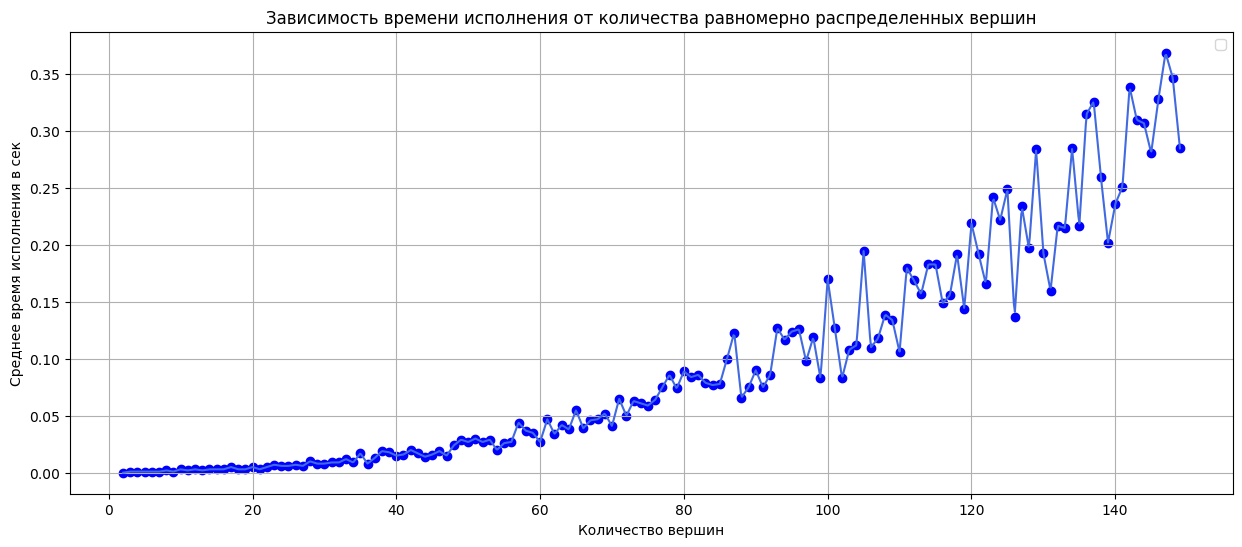

In [12]:
x_curve = np.linspace(min(num_points), max(num_points), 1000)
y_curve = np.interp(x_curve, num_points, times_uniform)

# Построение графика
plt.figure( figsize=(15, 6))

plt.scatter(num_points, times_uniform, color='blue')
plt.plot(x_curve, y_curve, color='royalblue')


plt.xlabel('Количество вершин')
plt.ylabel('Среднее время исполнения в сек')
plt.title('Зависимость времени исполнения от количества равномерно распределенных вершин')
plt.grid(True)
plt.legend()
plt.savefig('graph1.png')
plt.show()

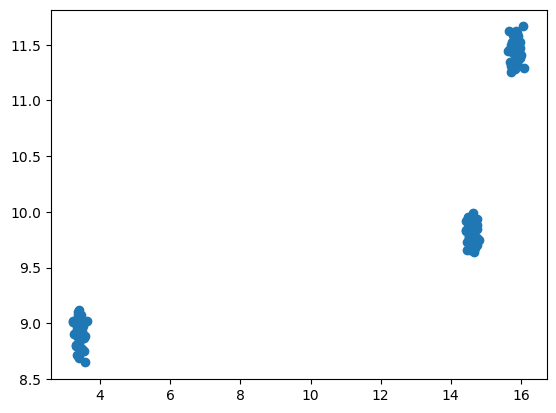

In [13]:
V_gauss = generate_random_points_gauss(150, 150//50, 1/100, 20, 20)
V_gauss.shape
plt.scatter(V_gauss[:, 0], V_gauss[:, 1])

In [14]:
num_points_per_claster = np.arange(2, 150, 1)
times_gauss = []
for points in num_points_per_claster:
    start_time = time.time()
    V_gauss = generate_random_points_gauss(150, 150//points, 1/100, 20, 20)
    dev_uniform = solve(V_gauss, 0, 1)
    end_time = time.time()
    times_gauss.append(end_time - start_time)
    if points % 10 == 0:
        print(points)

10
20
30
40
50
60
70
80
90
100
110
120
130
140


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


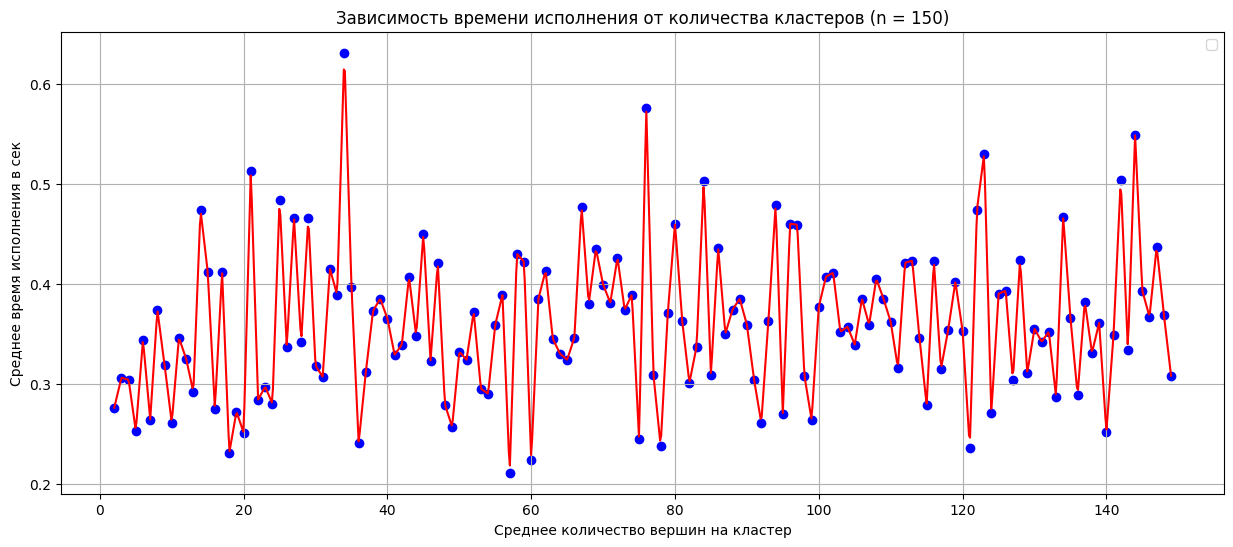

In [15]:
x_curve = np.linspace(min(num_points_per_claster), max(num_points_per_claster), 1000)
y_curve = np.interp(x_curve, num_points_per_claster, times_gauss)

# Построение графика
plt.figure( figsize=(15, 6))

plt.scatter(num_points_per_claster, times_gauss, color='blue')
plt.plot(x_curve, y_curve, color='red')


plt.xlabel('Среднее количество вершин на кластер')
plt.ylabel('Среднее время исполнения в сек')
plt.title('Зависимость времени исполнения от количества кластеров (n = 150)')
plt.grid(True)
plt.legend()
plt.savefig('graph2.png')
plt.show()